In [82]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import PIL
import datetime,os
import zipfile
import pytz
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_auc_score, roc_curve
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from datasets import load_dataset

from keras.utils import to_categorical 

from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Dense, Dropout 
from keras.layers import Flatten, BatchNormalization
from keras.optimizers import SGD

In [79]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
import pathlib
base_dir = ''
train_dir = os.path.join(base_dir, 'training_set/training_set/')
test_dir = os.path.join(base_dir, 'test_set/test_set/')
train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)

In [4]:
image_count = len(list(test_dir.glob('*/*.jpg')))
print(image_count)

2020


In [5]:
batch_size = 32
img_height = 280
img_width = 300

In [6]:
train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_ds = train_datagen.flow_from_directory(
  train_dir,
  subset='training',
  seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size,
  class_mode='binary')

Found 6404 images belonging to 2 classes.


In [8]:
val_ds = train_datagen.flow_from_directory(
  train_dir,
  subset='validation',
  seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size,
  class_mode='binary')

Found 1601 images belonging to 2 classes.


In [67]:
test_ds = test_datagen.flow_from_directory(
  test_dir,
  seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size,
  class_mode='binary',
  shuffle=False)
  

Found 2020 images belonging to 2 classes.


In [10]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [11]:
model = tf.keras.models.Sequential([
      data_augmentation,
      #tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])

l2_regularization = 0.01
regularizer = tf.keras.regularizers.l2(l2_regularization)
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        layer.kernel_regularizer = regularizer
                       
model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1.0e-4),
                metrics=['accuracy'])

In [12]:
logdir = os.path.join("logs", datetime.datetime.now(tz = pytz.timezone('Asia/Bangkok')).strftime("%Y%m%d-%H%M%S"))
logdir_csv = os.path.join("csv", datetime.datetime.now(tz = pytz.timezone('Asia/Bangkok')).strftime("%Y%m%d-%H%M%S"))
logdir_csv = logdir_csv + ".csv"
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_accuracy', 
    patience=10, 
    min_delta=0.001, 
    mode='max')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   
    patience=5,
    min_lr=1.0e-4,
    mode='min',
    cooldown = 3
)

checkpoint_path = 'model_checkpoints/'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',
    save_best_only=True,
    verbose=1
)

csv_log = CSVLogger("csv.csv")

def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback = [lr_scheduler ,early_stopping, tensorboard_callback , csv_log, checkpoint]


In [40]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 280, 300, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 278, 298, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 139, 149, 16)     0         
 2D)                                                             
                                                                 
 conv2d_21 (Conv2D)          (None, 137, 147, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 68, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 66, 71, 32)       

In [82]:
epochs=60
history = model.fit(
  train_ds,
  epochs=epochs,
  validation_data=val_ds,
  callbacks=callback
)

Epoch 1/60
201/201 [==============================] - ETA: 0s - loss: 0.5671 - accuracy: 0.7038
Epoch 1: val_loss improved from inf to 0.55982, saving model to model_checkpoints\


INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


201/201 [==============================] - 189s 940ms/step - loss: 0.5671 - accuracy: 0.7038 - val_loss: 0.5598 - val_accuracy: 0.7033 - lr: 1.0000e-04
Epoch 2/60
201/201 [==============================] - ETA: 0s - loss: 0.5606 - accuracy: 0.7071
Epoch 2: val_loss improved from 0.55982 to 0.54836, saving model to model_checkpoints\


INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


201/201 [==============================] - 214s 1s/step - loss: 0.5606 - accuracy: 0.7071 - val_loss: 0.5484 - val_accuracy: 0.7089 - lr: 1.0000e-04
Epoch 3/60
201/201 [==============================] - ETA: 0s - loss: 0.5549 - accuracy: 0.7175
Epoch 3: val_loss did not improve from 0.54836
201/201 [==============================] - 177s 879ms/step - loss: 0.5549 - accuracy: 0.7175 - val_loss: 0.5504 - val_accuracy: 0.7114 - lr: 1.0000e-04
Epoch 4/60
201/201 [==============================] - ETA: 0s - loss: 0.5490 - accuracy: 0.7153
Epoch 4: val_loss improved from 0.54836 to 0.53861, saving model to model_checkpoints\


INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


201/201 [==============================] - 186s 926ms/step - loss: 0.5490 - accuracy: 0.7153 - val_loss: 0.5386 - val_accuracy: 0.7214 - lr: 1.0000e-04
Epoch 5/60
201/201 [==============================] - ETA: 0s - loss: 0.5362 - accuracy: 0.7289
Epoch 5: val_loss did not improve from 0.53861
201/201 [==============================] - 177s 878ms/step - loss: 0.5362 - accuracy: 0.7289 - val_loss: 0.5433 - val_accuracy: 0.7214 - lr: 1.0000e-04
Epoch 6/60
201/201 [==============================] - ETA: 0s - loss: 0.5364 - accuracy: 0.7316
Epoch 6: val_loss improved from 0.53861 to 0.52513, saving model to model_checkpoints\


INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


201/201 [==============================] - 186s 925ms/step - loss: 0.5364 - accuracy: 0.7316 - val_loss: 0.5251 - val_accuracy: 0.7414 - lr: 1.0000e-04
Epoch 7/60
201/201 [==============================] - ETA: 0s - loss: 0.5214 - accuracy: 0.7425
Epoch 7: val_loss did not improve from 0.52513
201/201 [==============================] - 176s 876ms/step - loss: 0.5214 - accuracy: 0.7425 - val_loss: 0.5429 - val_accuracy: 0.7264 - lr: 1.0000e-04
Epoch 8/60
201/201 [==============================] - ETA: 0s - loss: 0.5161 - accuracy: 0.7455
Epoch 8: val_loss improved from 0.52513 to 0.51626, saving model to model_checkpoints\


INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


201/201 [==============================] - 187s 930ms/step - loss: 0.5161 - accuracy: 0.7455 - val_loss: 0.5163 - val_accuracy: 0.7502 - lr: 1.0000e-04
Epoch 9/60
201/201 [==============================] - ETA: 0s - loss: 0.5057 - accuracy: 0.7497
Epoch 9: val_loss improved from 0.51626 to 0.51006, saving model to model_checkpoints\


INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


201/201 [==============================] - 187s 927ms/step - loss: 0.5057 - accuracy: 0.7497 - val_loss: 0.5101 - val_accuracy: 0.7527 - lr: 1.0000e-04
Epoch 10/60
201/201 [==============================] - ETA: 0s - loss: 0.5043 - accuracy: 0.7512
Epoch 10: val_loss did not improve from 0.51006
201/201 [==============================] - 177s 880ms/step - loss: 0.5043 - accuracy: 0.7512 - val_loss: 0.5106 - val_accuracy: 0.7533 - lr: 1.0000e-04
Epoch 11/60
201/201 [==============================] - ETA: 0s - loss: 0.4987 - accuracy: 0.7561
Epoch 11: val_loss did not improve from 0.51006
201/201 [==============================] - 177s 878ms/step - loss: 0.4987 - accuracy: 0.7561 - val_loss: 0.5133 - val_accuracy: 0.7495 - lr: 1.0000e-04
Epoch 12/60
201/201 [==============================] - ETA: 0s - loss: 0.4903 - accuracy: 0.7669
Epoch 12: val_loss improved from 0.51006 to 0.50681, saving model to model_checkpoints\


INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


201/201 [==============================] - 186s 924ms/step - loss: 0.4903 - accuracy: 0.7669 - val_loss: 0.5068 - val_accuracy: 0.7533 - lr: 1.0000e-04
Epoch 13/60
201/201 [==============================] - ETA: 0s - loss: 0.4836 - accuracy: 0.7631
Epoch 13: val_loss did not improve from 0.50681
201/201 [==============================] - 177s 881ms/step - loss: 0.4836 - accuracy: 0.7631 - val_loss: 0.5164 - val_accuracy: 0.7502 - lr: 1.0000e-04
Epoch 14/60
201/201 [==============================] - ETA: 0s - loss: 0.4802 - accuracy: 0.7692
Epoch 14: val_loss did not improve from 0.50681
201/201 [==============================] - 177s 880ms/step - loss: 0.4802 - accuracy: 0.7692 - val_loss: 0.5775 - val_accuracy: 0.7270 - lr: 1.0000e-04
Epoch 15/60
201/201 [==============================] - ETA: 0s - loss: 0.4710 - accuracy: 0.7762
Epoch 15: val_loss did not improve from 0.50681
201/201 [==============================] - 178s 886ms/step - loss: 0.4710 - accuracy: 0.7762 - val_loss: 0.55

INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


201/201 [==============================] - 189s 939ms/step - loss: 0.4707 - accuracy: 0.7811 - val_loss: 0.4806 - val_accuracy: 0.7726 - lr: 1.0000e-04
Epoch 17/60
201/201 [==============================] - ETA: 0s - loss: 0.4592 - accuracy: 0.7811
Epoch 17: val_loss did not improve from 0.48057
201/201 [==============================] - 178s 885ms/step - loss: 0.4592 - accuracy: 0.7811 - val_loss: 0.6263 - val_accuracy: 0.7127 - lr: 1.0000e-04
Epoch 18/60
201/201 [==============================] - ETA: 0s - loss: 0.4602 - accuracy: 0.7812
Epoch 18: val_loss improved from 0.48057 to 0.47057, saving model to model_checkpoints\


INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


201/201 [==============================] - 185s 920ms/step - loss: 0.4602 - accuracy: 0.7812 - val_loss: 0.4706 - val_accuracy: 0.7714 - lr: 1.0000e-04
Epoch 19/60
201/201 [==============================] - ETA: 0s - loss: 0.4547 - accuracy: 0.7892
Epoch 19: val_loss did not improve from 0.47057
201/201 [==============================] - 177s 880ms/step - loss: 0.4547 - accuracy: 0.7892 - val_loss: 0.5716 - val_accuracy: 0.7439 - lr: 1.0000e-04
Epoch 20/60
201/201 [==============================] - ETA: 0s - loss: 0.4445 - accuracy: 0.7915
Epoch 20: val_loss did not improve from 0.47057
201/201 [==============================] - 180s 895ms/step - loss: 0.4445 - accuracy: 0.7915 - val_loss: 0.5371 - val_accuracy: 0.7639 - lr: 1.0000e-04
Epoch 21/60
201/201 [==============================] - ETA: 0s - loss: 0.4454 - accuracy: 0.7911
Epoch 21: val_loss did not improve from 0.47057
201/201 [==============================] - 177s 879ms/step - loss: 0.4454 - accuracy: 0.7911 - val_loss: 0.48

INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


201/201 [==============================] - 186s 922ms/step - loss: 0.4403 - accuracy: 0.7925 - val_loss: 0.4696 - val_accuracy: 0.7776 - lr: 1.0000e-04
Epoch 23/60
201/201 [==============================] - ETA: 0s - loss: 0.4363 - accuracy: 0.7993
Epoch 23: val_loss did not improve from 0.46955
201/201 [==============================] - 177s 882ms/step - loss: 0.4363 - accuracy: 0.7993 - val_loss: 0.4991 - val_accuracy: 0.7645 - lr: 1.0000e-04
Epoch 24/60
201/201 [==============================] - ETA: 0s - loss: 0.4408 - accuracy: 0.7900
Epoch 24: val_loss improved from 0.46955 to 0.46192, saving model to model_checkpoints\


INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


201/201 [==============================] - 186s 923ms/step - loss: 0.4408 - accuracy: 0.7900 - val_loss: 0.4619 - val_accuracy: 0.7889 - lr: 1.0000e-04
Epoch 25/60
201/201 [==============================] - ETA: 0s - loss: 0.4324 - accuracy: 0.8022
Epoch 25: val_loss did not improve from 0.46192
201/201 [==============================] - 177s 882ms/step - loss: 0.4324 - accuracy: 0.8022 - val_loss: 0.5093 - val_accuracy: 0.7695 - lr: 1.0000e-04
Epoch 26/60
201/201 [==============================] - ETA: 0s - loss: 0.4287 - accuracy: 0.8051
Epoch 26: val_loss did not improve from 0.46192
201/201 [==============================] - 178s 881ms/step - loss: 0.4287 - accuracy: 0.8051 - val_loss: 0.4655 - val_accuracy: 0.7858 - lr: 1.0000e-04
Epoch 27/60
201/201 [==============================] - ETA: 0s - loss: 0.4215 - accuracy: 0.8106
Epoch 27: val_loss did not improve from 0.46192
201/201 [==============================] - 177s 880ms/step - loss: 0.4215 - accuracy: 0.8106 - val_loss: 0.46

INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


201/201 [==============================] - 186s 922ms/step - loss: 0.4158 - accuracy: 0.8150 - val_loss: 0.4525 - val_accuracy: 0.7970 - lr: 1.0000e-04
Epoch 29/60
201/201 [==============================] - ETA: 0s - loss: 0.4194 - accuracy: 0.8117
Epoch 29: val_loss improved from 0.45253 to 0.44853, saving model to model_checkpoints\


INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


201/201 [==============================] - 186s 924ms/step - loss: 0.4194 - accuracy: 0.8117 - val_loss: 0.4485 - val_accuracy: 0.7926 - lr: 1.0000e-04
Epoch 30/60
201/201 [==============================] - ETA: 0s - loss: 0.4128 - accuracy: 0.8093
Epoch 30: val_loss did not improve from 0.44853
201/201 [==============================] - 177s 880ms/step - loss: 0.4128 - accuracy: 0.8093 - val_loss: 0.5423 - val_accuracy: 0.7614 - lr: 1.0000e-04
Epoch 31/60
201/201 [==============================] - ETA: 0s - loss: 0.4075 - accuracy: 0.8170
Epoch 31: val_loss improved from 0.44853 to 0.44002, saving model to model_checkpoints\


INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


201/201 [==============================] - 186s 923ms/step - loss: 0.4075 - accuracy: 0.8170 - val_loss: 0.4400 - val_accuracy: 0.7964 - lr: 9.0484e-05
Epoch 32/60
201/201 [==============================] - ETA: 0s - loss: 0.3941 - accuracy: 0.8217
Epoch 32: val_loss did not improve from 0.44002
201/201 [==============================] - 177s 881ms/step - loss: 0.3941 - accuracy: 0.8217 - val_loss: 0.5171 - val_accuracy: 0.7733 - lr: 8.1873e-05
Epoch 33/60
201/201 [==============================] - ETA: 0s - loss: 0.3937 - accuracy: 0.8207
Epoch 33: val_loss did not improve from 0.44002
201/201 [==============================] - 177s 881ms/step - loss: 0.3937 - accuracy: 0.8207 - val_loss: 0.4994 - val_accuracy: 0.7889 - lr: 7.4082e-05
Epoch 34/60
201/201 [==============================] - ETA: 0s - loss: 0.3810 - accuracy: 0.8310
Epoch 34: val_loss did not improve from 0.44002
201/201 [==============================] - 178s 885ms/step - loss: 0.3810 - accuracy: 0.8310 - val_loss: 0.49

INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


201/201 [==============================] - 186s 927ms/step - loss: 0.3637 - accuracy: 0.8407 - val_loss: 0.4296 - val_accuracy: 0.8089 - lr: 3.6788e-05
Epoch 41/60
201/201 [==============================] - ETA: 0s - loss: 0.3546 - accuracy: 0.8440
Epoch 41: val_loss improved from 0.42961 to 0.42312, saving model to model_checkpoints\


INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


201/201 [==============================] - 186s 926ms/step - loss: 0.3546 - accuracy: 0.8440 - val_loss: 0.4231 - val_accuracy: 0.8126 - lr: 3.3287e-05
Epoch 42/60
201/201 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.8459
Epoch 42: val_loss did not improve from 0.42312
201/201 [==============================] - 177s 881ms/step - loss: 0.3562 - accuracy: 0.8459 - val_loss: 0.5004 - val_accuracy: 0.8020 - lr: 3.0119e-05
Epoch 43/60
201/201 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.8442
Epoch 43: val_loss did not improve from 0.42312
201/201 [==============================] - 177s 882ms/step - loss: 0.3555 - accuracy: 0.8442 - val_loss: 0.4556 - val_accuracy: 0.8039 - lr: 2.7253e-05
Epoch 44/60
201/201 [==============================] - ETA: 0s - loss: 0.3524 - accuracy: 0.8471
Epoch 44: val_loss did not improve from 0.42312
201/201 [==============================] - 178s 883ms/step - loss: 0.3524 - accuracy: 0.8471 - val_loss: 0.44

In [92]:
model.save('Model_catdog_1')

INFO:tensorflow:Assets written to: Model_catdog_1\assets


INFO:tensorflow:Assets written to: Model_catdog_1\assets


In [89]:
best_model = keras.models.load_model("model_checkpoints")

In [91]:
best_model.evaluate(val_ds)
model.evaluate(val_ds)

51/51 [==============================] - 9s 171ms/step - loss: 0.4497 - accuracy: 0.8070


[0.4497000575065613, 0.8069956302642822]

In [90]:
best_model.evaluate(test_ds)
model.evaluate(test_ds)

64/64 [==============================] - 11s 172ms/step - loss: 0.4203 - accuracy: 0.8312


[0.420322060585022, 0.8311881422996521]

In [13]:
reconstructed_model = keras.models.load_model("Model_catdog")

In [14]:
reconstructed_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 280, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 278, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 139, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 137, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 68, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 66, 71, 32)       

In [15]:
reconstructed_model.evaluate(test_ds)

64/64 [==============================] - 75s 884ms/step - loss: 0.2882 - accuracy: 0.8842


[0.2881962060928345, 0.8841584324836731]

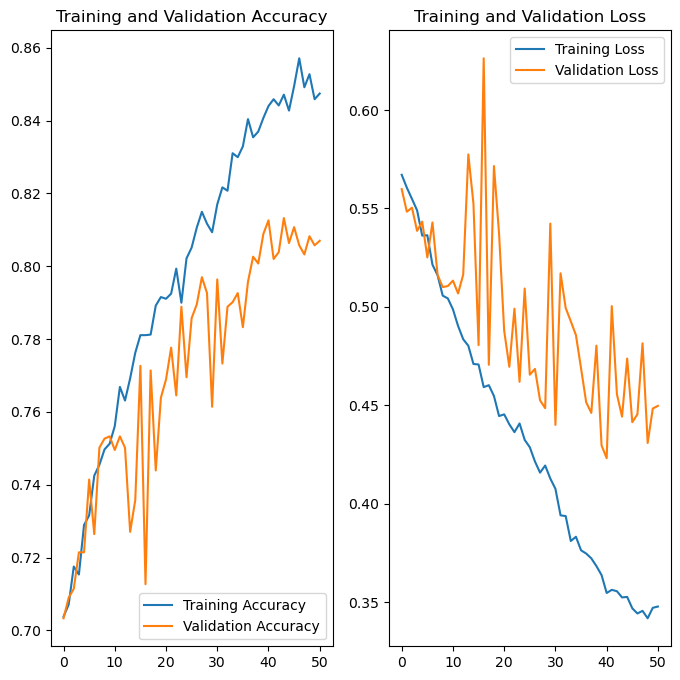

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs)
epochs_range = range(0,51)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
tensorboard --logdir logs

In [89]:
reconstructed_model.predict(test_ds)


64/64 [==============================] - 10s 154ms/step


array([[0.7624107 ],
       [0.2253442 ],
       [0.00788839],
       ...,
       [0.04714828],
       [0.88291293],
       [0.9250804 ]], dtype=float32)

In [33]:
test_ds.classes

array([0, 0, 0, ..., 1, 1, 1])

In [90]:
from PIL import Image
# Load and preprocess the image
image_path = 'test_set/test_set/cats/cat.4001.jpg'
#image_path = 'test_set/test_set/dogs/dog.4999.jpg'
image_size = (300, 280)  # Adjust the size according to your model's input shape

image = Image.open(image_path)
image = image.resize(image_size)
image = np.array(image)
image = image / 255.0  # Normalize pixel values if required

# Reshape the image to match the input shape expected by the model
image = np.expand_dims(image, axis=0)

# Make a prediction
predictions = reconstructed_model.predict(image)
predicted_class =  np.round(predictions).astype(int)

# Display the predicted class
print("Predicted class:", predicted_class)
print("Predicted :", predictions)

1/1 [==============================] - 0s 56ms/step
Predicted class: [[1]]
Predicted : [[0.6107224]]


64/64 [==============================] - 9s 145ms/step
Confusion Matrix
[[882 127]
 [107 904]]
Classification Report
              precision    recall  f1-score   support

        cats       0.89      0.87      0.88      1009
        dogs       0.88      0.89      0.89      1011

    accuracy                           0.88      2020
   macro avg       0.88      0.88      0.88      2020
weighted avg       0.88      0.88      0.88      2020



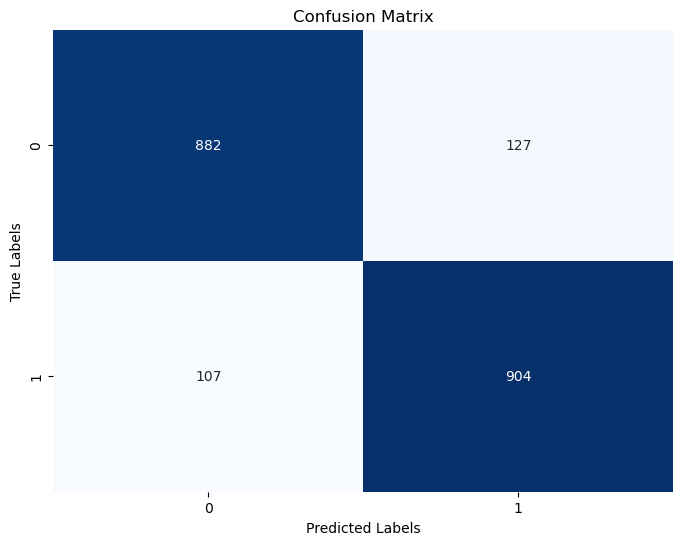

In [75]:
Y_pred = reconstructed_model.predict(test_ds)
y_pred = np.round(Y_pred).astype(int)
print('Confusion Matrix')
cm = confusion_matrix(test_ds.classes, y_pred)
print(cm)
print('Classification Report')
target_names = ['Cats', 'Dogs']
print(classification_report(test_ds.classes, y_pred, target_names=list(test_ds.class_indices.keys())))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_ds.classes, y_pred), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

AUC score: 0.8841484993123218


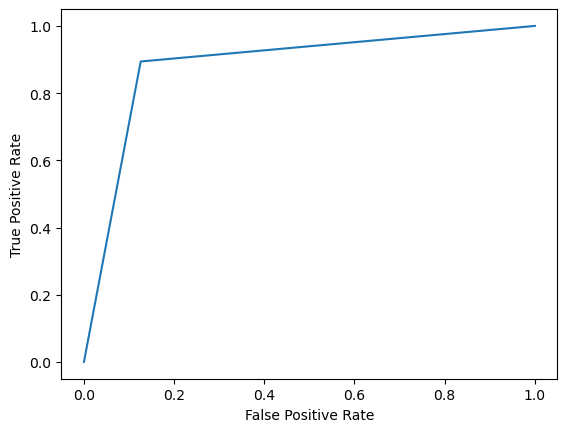

In [88]:
fpr, tpr, thresholds = roc_curve(test_ds.classes, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print(f'AUC score: {roc_auc_score(test_ds.classes, y_pred)}')